Loading datasets

In [1]:
import pandas as pd

btc = pd.read_csv("/Users/altemir_1/Desktop/BTC-Stock-Market-Analysis/data/processed/btc_processed.csv")
sp500 = pd.read_csv("/Users/altemir_1/Desktop/BTC-Stock-Market-Analysis/data/processed/sp500_processed.csv")
investment_sectors = pd.read_csv("/Users/altemir_1/Desktop/BTC-Stock-Market-Analysis/data/processed/all_sectors_processed.csv")


### Installing necessary librareis

In [14]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 6.3 MB/s eta 0:00:0000:0100:01


### Helper Functions

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def remove_outliers(df, columns):
    """
    Removes outliers from specified columns in a DataFrame using the IQR method.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list of str): List of column names to check for outliers.

    Returns:
    - pd.DataFrame: DataFrame with outliers removed.
    """
    df_clean = df.copy()
    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
        
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

def plot_price_volume_correlation_with_outlier_removal(df, price_col='price', volume_col='volume'):
    """
    Removes outliers from price and volume columns, calculates, and plots the correlation.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing price and volume columns.
    - price_col (str): The column name for prices (default: 'price').
    - volume_col (str): The column name for volumes (default: 'volume').

    Returns:
    - float: Correlation coefficient between price and volume after outlier removal.
    """
    if price_col not in df.columns or volume_col not in df.columns:
        raise ValueError(f"Columns '{price_col}' and/or '{volume_col}' not found in the DataFrame.")
    
    # Remove outliers from price and volume
    df_clean = remove_outliers(df, [price_col, volume_col])
    
    # Calculate correlation
    correlation = df_clean[price_col].corr(df_clean[volume_col])
    
    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_clean, x=price_col, y=volume_col, alpha=0.6, color="blue")
    plt.title(f"Price vs Volume Correlation (No Outliers): {correlation:.2f}", fontsize=16)
    plt.xlabel("Price", fontsize=12)
    plt.ylabel("Volume", fontsize=12)
    plt.grid(True)
    plt.show()
    
    return correlation


def plot_autocorrelation(data, column, lags=20):
    """
    Plots the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
    for a given column in the dataset.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing the time series data.
    - column (str): The column name to analyze.
    - lags (int): The number of lags to include in the plots (default: 40).

    Returns:
    None
    """
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    plt.figure(figsize=(12, 10))

    # ACF Plot
    plt.subplot(2, 1, 1)
    plot_acf(data[column].dropna(), lags=lags, title=f"ACF for {column}", ax=plt.gca())

    # PACF Plot
    plt.subplot(2, 1, 2)
    plot_pacf(data[column].dropna(), lags=lags, title=f"PACF for {column}", ax=plt.gca())

    plt.tight_layout()
    plt.show()


def plot_cross_correlation(df, col1, col2, lags=20):
    """
    Plots the cross-correlation between two time series columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing time series data.
    - col1 (str): Name of the first column (e.g., 'price').
    - col2 (str): Name of the second column (e.g., 'volume').
    - lags (int): Number of lags to consider for cross-correlation.

    Returns:
    - None: Displays the cross-correlation plot.
    """
    if col1 not in df.columns or col2 not in df.columns:
        raise ValueError(f"Columns '{col1}' and/or '{col2}' not found in the DataFrame.")

    # Drop rows with NaN values in selected columns
    clean_df = df[[col1, col2]].dropna()

    # Compute cross-correlation
    cross_corr = [clean_df[col1].corr(clean_df[col2].shift(lag)) for lag in range(-lags, lags + 1)]

    # Plot cross-correlation
    plt.figure(figsize=(10, 6))
    plt.bar(range(-lags, lags + 1), cross_corr, color='blue')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axhline(0.2, color='red', linestyle='--', linewidth=1)  # Threshold for significance
    plt.axhline(-0.2, color='red', linestyle='--', linewidth=1)
    plt.title(f"Cross-Correlation between '{col1}' and '{col2}'")
    plt.xlabel("Lag")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.show()

def plot_relationship_btc_sp500(btc_df, sp500_df, price_col='price', date_col='date'):
    """
    Plots the relationship between BTC prices and S&P 500 prices using a scatter plot and calculates correlation.

    Parameters:
    - btc_df (pd.DataFrame): BTC DataFrame with date and price columns.
    - sp500_df (pd.DataFrame): S&P 500 DataFrame with date and price columns.
    - price_col (str): Column name for prices (default: 'price').
    - date_col (str): Column name for date (default: 'date').

    Returns:
    - None: Displays scatter plot and prints correlation coefficient.
    """
    # Merge BTC and S&P 500 data on the date column
    merged_df = pd.merge(
        btc_df[[date_col, price_col]].rename(columns={price_col: 'BTC_Price'}),
        sp500_df[[date_col, price_col]].rename(columns={price_col: 'SP500_Price'}),
        on=date_col,
        how='inner'
    )

    # Calculate the correlation between BTC and S&P 500
    correlation = merged_df['BTC_Price'].corr(merged_df['SP500_Price'])

    # Scatter plot of BTC vs S&P 500
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=merged_df['SP500_Price'], y=merged_df['BTC_Price'], alpha=0.6, color='purple')
    plt.title(f"Relationship Between BTC and S&P 500\nCorrelation: {correlation:.2f}", fontsize=14)
    plt.xlabel("S&P 500 Price", fontsize=12)
    plt.ylabel("BTC Price", fontsize=12)
    plt.grid(True)
    plt.show()

    # Print correlation
    print(f"Correlation between BTC and S&P 500: {correlation:.2f}")

def remove_outliers_iqr(df, column):
    """
    Removes outliers from a column using the IQR (Interquartile Range) method.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def plot_volume_relationship(btc_df, sp500_df, volume_col='volume', date_col='date'):
    """
    Plots the relationship between BTC volume and S&P 500 volume after removing outliers.

    Parameters:
    - btc_df (pd.DataFrame): BTC DataFrame with date and volume columns.
    - sp500_df (pd.DataFrame): S&P 500 DataFrame with date and volume columns.
    - volume_col (str): Column name for volumes (default: 'volume').
    - date_col (str): Column name for date (default: 'date').

    Returns:
    - None: Displays scatter plot with correlation coefficient.
    """
    # Merge BTC and S&P 500 data on the date column
    merged_df = pd.merge(
        btc_df[[date_col, volume_col]].rename(columns={volume_col: 'BTC_Volume'}),
        sp500_df[[date_col, volume_col]].rename(columns={volume_col: 'SP500_Volume'}),
        on=date_col,
        how='inner'
    )

    # Remove outliers for both volumes
    merged_df = remove_outliers_iqr(merged_df, 'BTC_Volume')
    merged_df = remove_outliers_iqr(merged_df, 'SP500_Volume')

    # Calculate correlation
    correlation = merged_df['BTC_Volume'].corr(merged_df['SP500_Volume'])

    # Scatter plot for BTC volume vs SP500 volume
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='SP500_Volume', y='BTC_Volume', data=merged_df, alpha=0.6, color='green')
    plt.title(f"Relationship Between BTC Volume and S&P 500 Volume\nCorrelation: {correlation:.2f}", fontsize=14)
    plt.xlabel("S&P 500 Volume", fontsize=12)
    plt.ylabel("BTC Volume", fontsize=12)
    plt.grid(True)
    plt.show()

    print(f"Correlation between BTC Volume and S&P 500 Volume: {correlation:.2f}")


def plot_correlation_matrix(btc_df, sectors_df, price_col='price', date_col='date'):
    """
    Calculates and plots the correlation matrix between BTC prices and sector prices.

    Parameters:
    - btc_df (pd.DataFrame): DataFrame containing BTC price data.
    - sectors_df (pd.DataFrame): DataFrame containing sector price data with 'date' and 'sector' columns.
    - price_col (str): Column name for prices (default: 'price').
    - date_col (str): Column name for dates (default: 'date').

    Returns:
    - None: Displays a heatmap of the correlation matrix.
    """
    # Prepare BTC data
    btc_data = btc_df[[date_col, price_col]].rename(columns={price_col: 'BTC_Price'})

    # Pivot sectors data to wide format
    sectors_pivot = sectors_df.pivot(index=date_col, columns='sector', values=price_col)

    # Merge BTC prices with sector prices
    merged_df = pd.merge(btc_data, sectors_pivot, on=date_col, how='inner')

    # Drop non-numeric columns before calculating correlation
    numeric_df = merged_df.select_dtypes(include=[float, int])

    # Calculate correlation matrix
    correlation_matrix = numeric_df.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        cmap='RdYlGn', 
        fmt=".2f", 
        center=0,
        linewidths=0.5
    )
    plt.title("Correlation Matrix: BTC and Investment Sectors", fontsize=14)
    plt.show()






### Price/Volume correlation

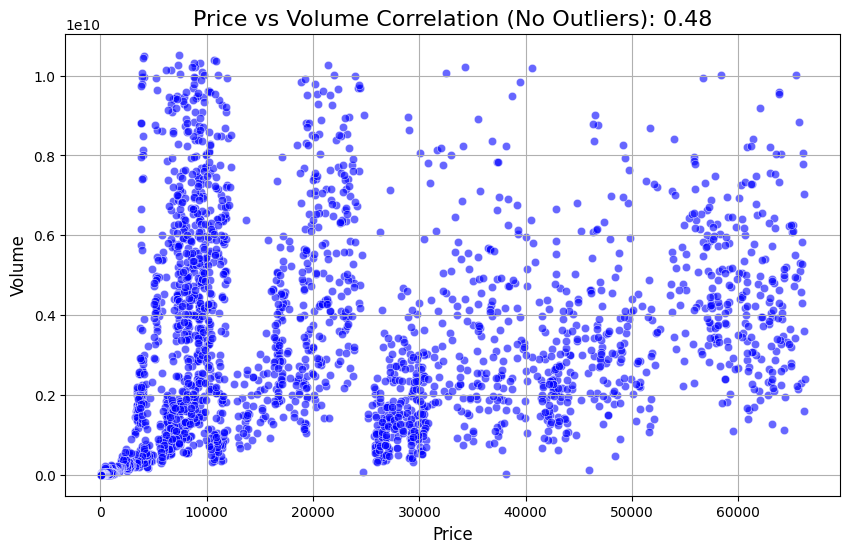

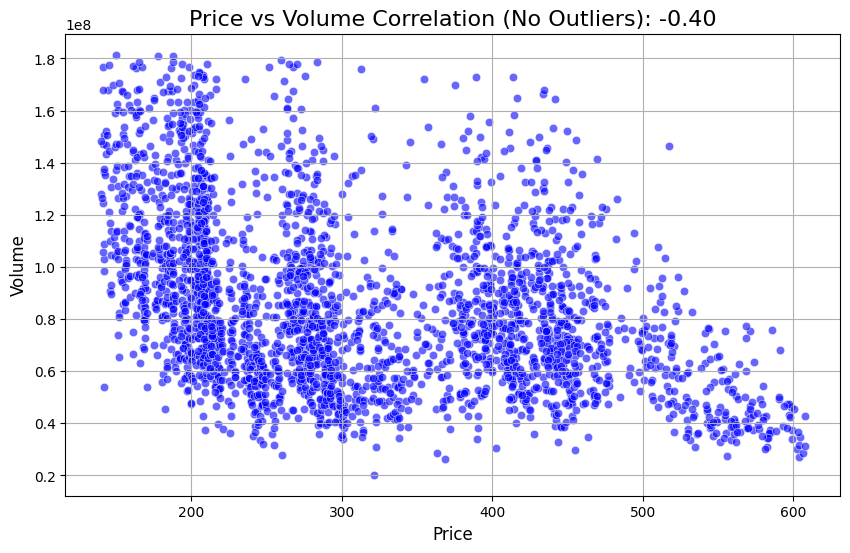

In [13]:
btc_volume_price_correlation = plot_price_volume_correlation_with_outlier_removal(btc)
sp500_volume_price_correlation = plot_price_volume_correlation_with_outlier_removal(sp500)

PACF and ACF

Bitcoins autocorrelation values


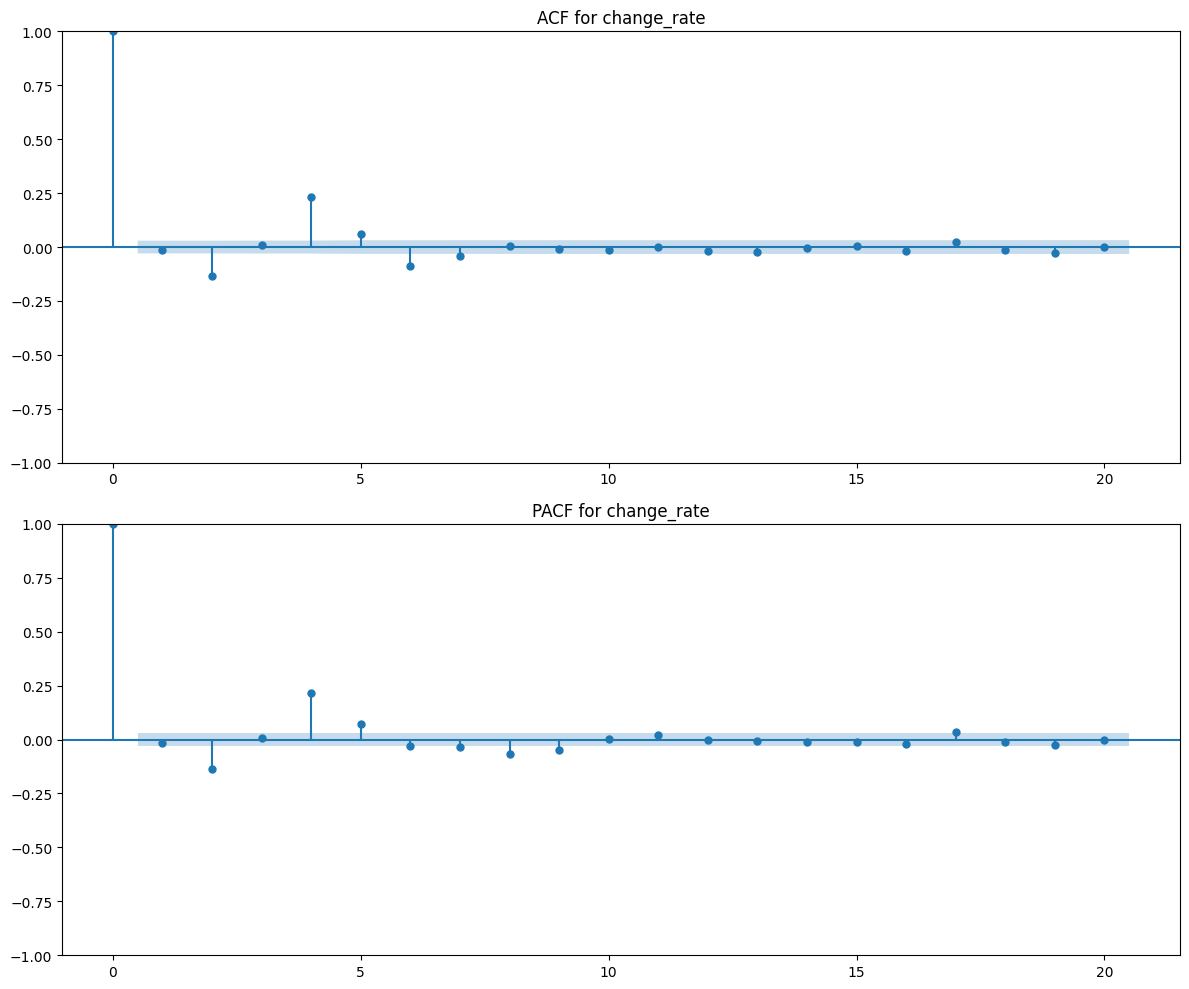

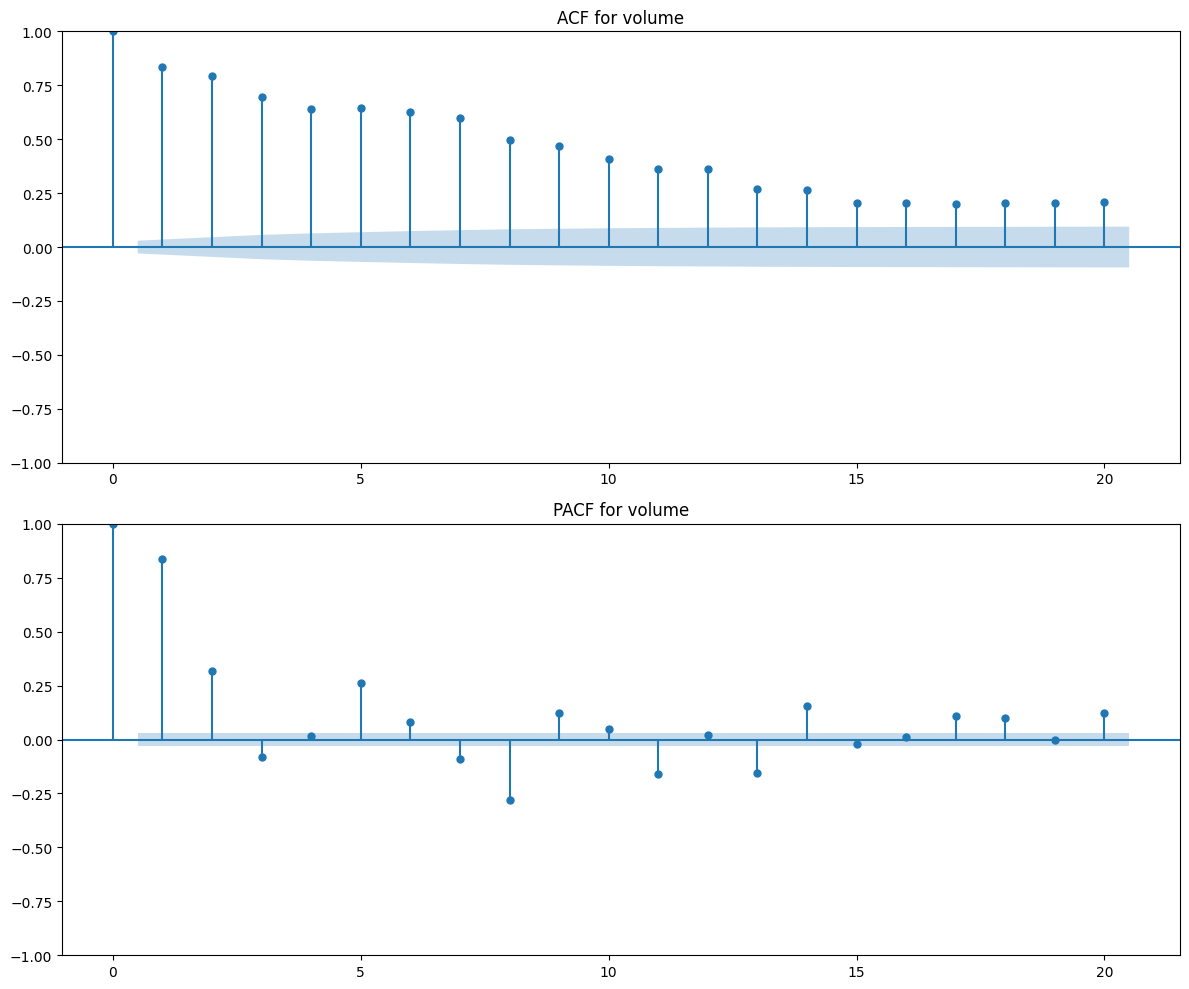

S&P500 autocorrelation values


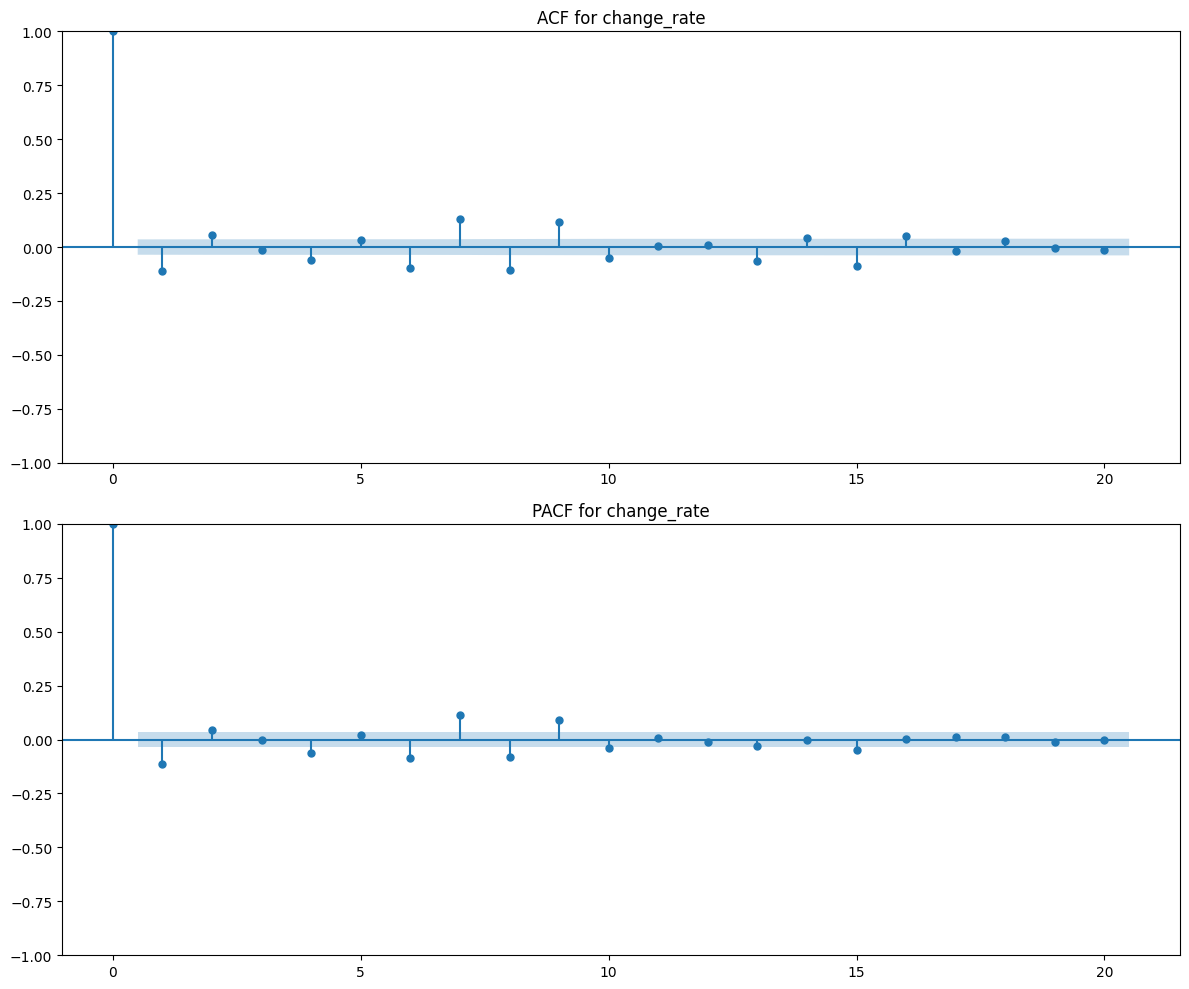

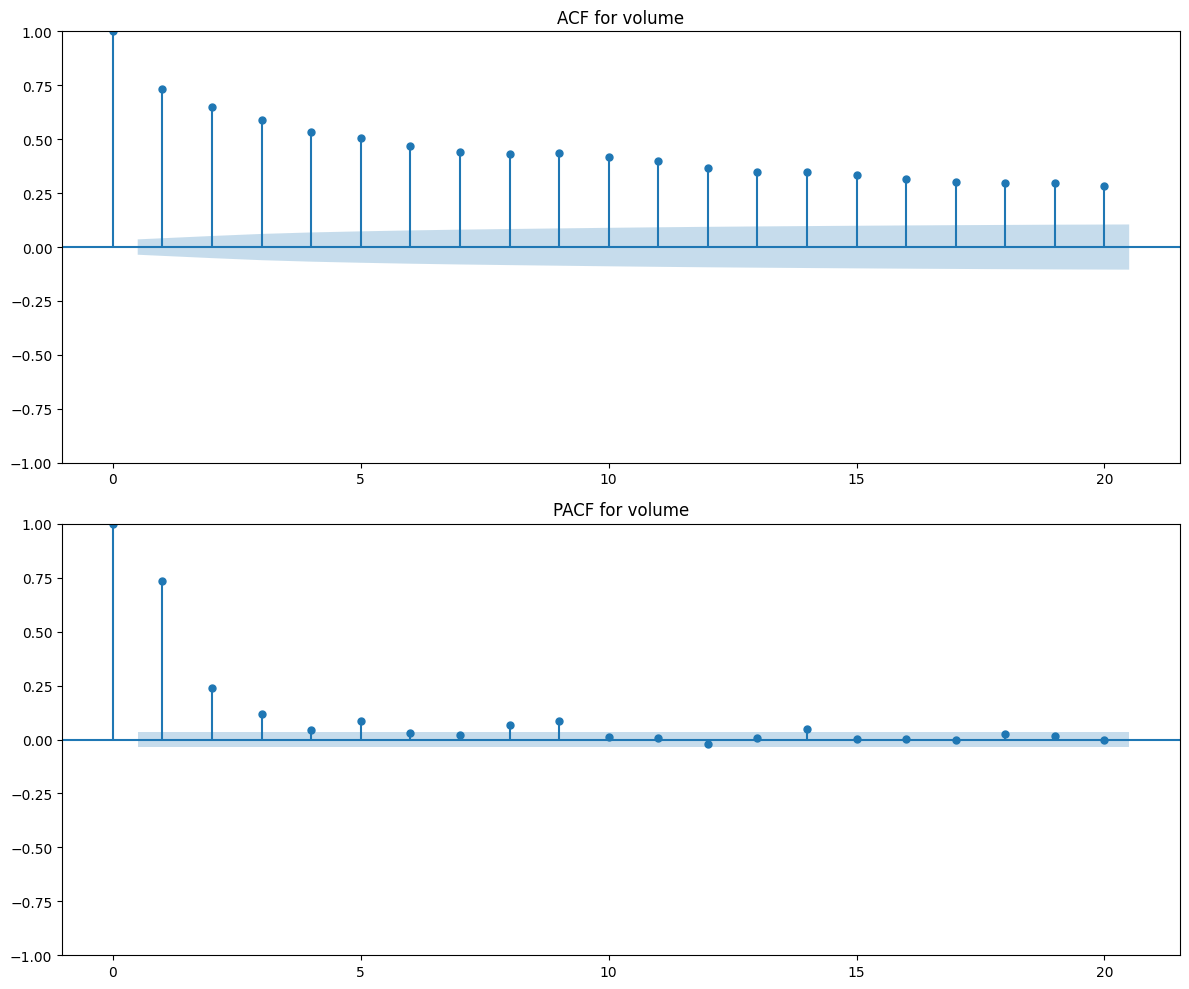

In [19]:
print("Bitcoins autocorrelation values")
plot_autocorrelation(btc, column="change_rate", lags=20)
plot_autocorrelation(btc, column="volume", lags=20)

print("S&P500 autocorrelation values")
plot_autocorrelation(sp500, column="change_rate", lags=20)
plot_autocorrelation(sp500, column="volume", lags=20)

Cross correlation between price and volume

Bitcoin cross-correlation


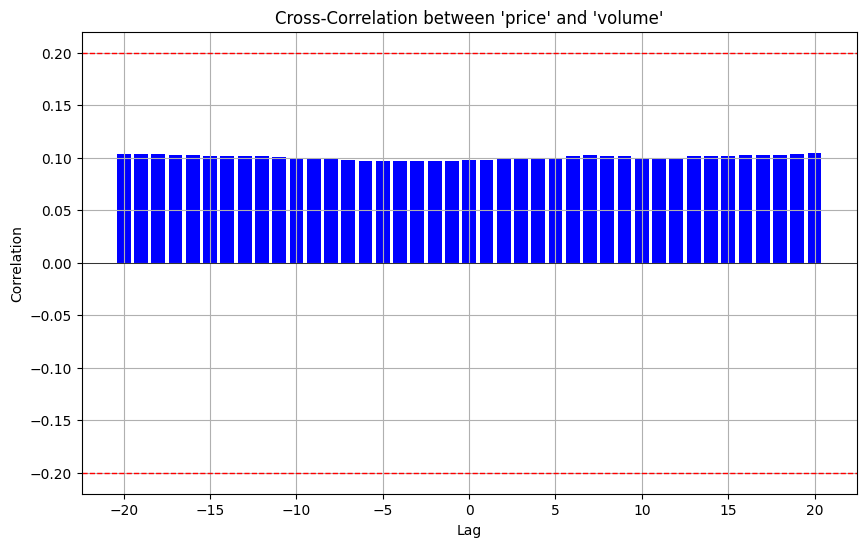

S&P500 cross-correlation


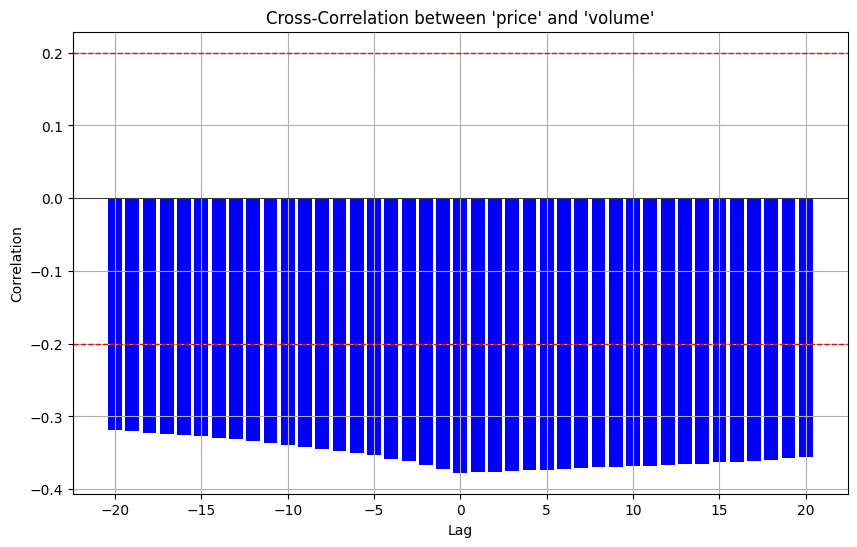

In [22]:
print("Bitcoin cross-correlation")
plot_cross_correlation(btc, col1="price", col2="volume", lags=20)
print("S&P500 cross-correlation")
plot_cross_correlation(sp500, col1="price", col2="volume", lags=20)

### BTC, SP500 and investment sectors relationship

Price relationship

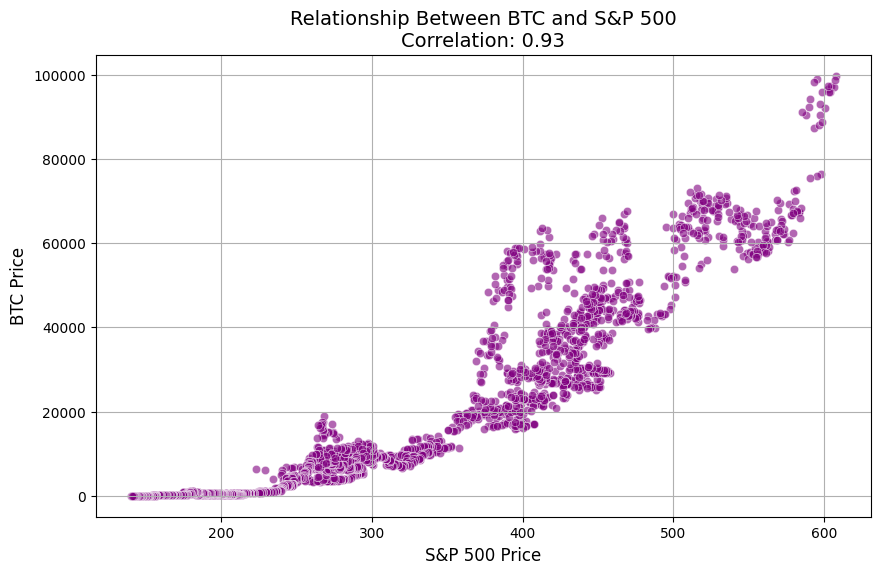

Correlation between BTC and S&P 500: 0.93


In [24]:
plot_relationship_btc_sp500(btc, sp500, "price", "date")

Volume relationship

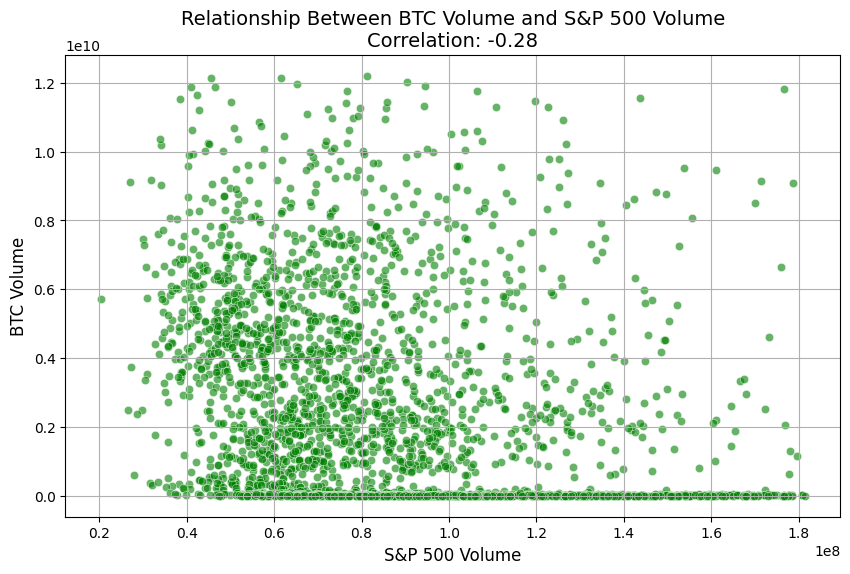

Correlation between BTC Volume and S&P 500 Volume: -0.28


In [27]:
plot_volume_relationship(btc, sp500, volume_col='volume', date_col='date')

BTC and investment sectors relationship

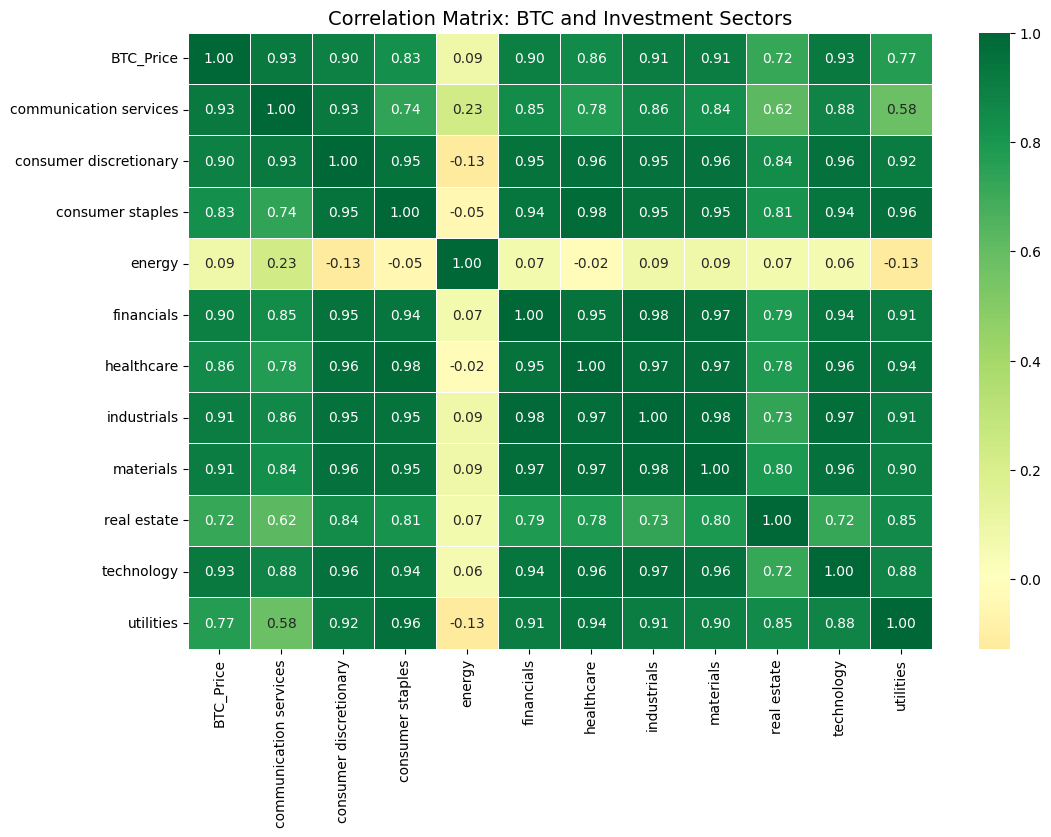

In [32]:
plot_correlation_matrix(btc, investment_sectors, "price", "date")